# 06-Extended Sources

While preparing the note for extended sources, I realized that the detailed explanations are either well explained by so many people, e.g., SExtractor user guides (included in the ``references`` directory of this repo) which provide extensive explanations on the API. Also see [``photutils.segmentation`` documentation](https://photutils.readthedocs.io/en/stable/segmentation.html) and [``photutils.isophot`` documentation](https://photutils.readthedocs.io/en/stable/isophote.html) for some educational tutorials. Moreover, there are some *hidden* tutorials such as [this online materials](https://photutils.readthedocs.io/en/stable/isophote.html#additional-example-notebooks-online). I urge you to follow those tutorials, but not only those, but also the referenced publications like Jedrzejewski (1987; MNRAS 226, 747). 

Since the remaining part is more like advanced science, I don't really think it is necessary to make any more explanatory notes. Here, I will show you *just another tutorial example* similar to that shown in ``photutils`` documentations above, but without much explanations. So **I recommend you to first look at the ``photutils`` documentations linked above, and then come back to this note to see this because it is nothing more than a simple and inferior, nearly copied-and-pasted summary**.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/ysbach/anaconda3/lib/python3.6/site-packages/ysfitsutilpy-0.0.2.dev0-py3.6.egg/ysfitsutilpy/ccdutil.py:106: UserWarning: Since Cutout2D is for small image crop, astropy do not currently support distortion in WCS. This may result in slightly inaccurate WCS calculation in the future.
  + "slightly inaccurate WCS calculation in the future.")


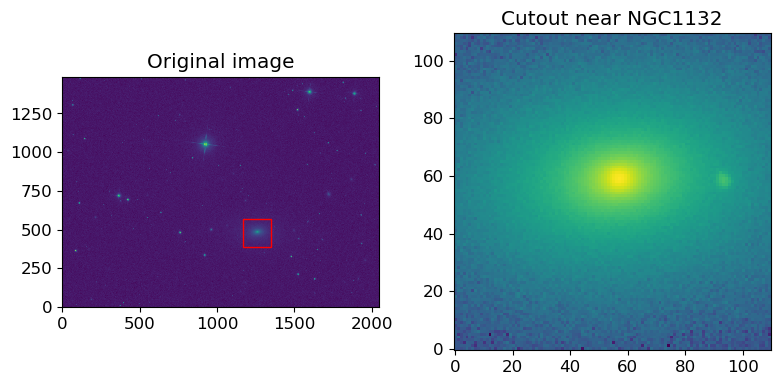

In [125]:
from pathlib import Path
import numpy as np

from astropy.table import Table
from astropy.nddata import CCDData
from astropy.visualization import ZScaleInterval, LogStretch, ImageNormalize, imshow_norm
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel

from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, detect_sources, deblend_sources, Background2D, source_properties

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysfitsutilpy as yfu

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path("../data")
ccd_all = yfu.load_ccd(DATAPATH / "ngc1132_r.fits")
ccd = yfu.cutccd(ccd_all, position=(1260, 480), size=(110, 110))
data_all = ccd_all.data
data = ccd.data

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
imshow_norm(data_all, axs[0], stretch=LogStretch(), origin='lower')
axs[0].plot(1260, 480, 's', ms=20, mfc='none', mec='r')
axs[0].set_title("Original image")
imshow_norm(data, axs[1], stretch=LogStretch(), origin='lower')
axs[1].set_title("Cutout near NGC1132")
plt.tight_layout()
plt.show()

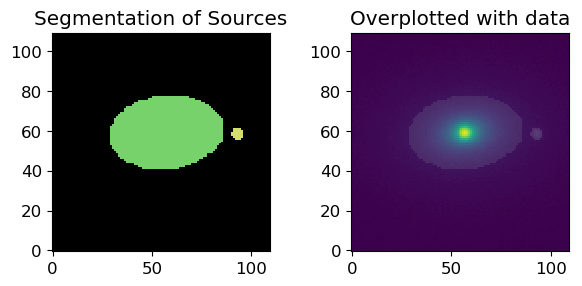

In [123]:
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5, std_ddof=1)
threshold = med + 3 * std
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)
axs[0].imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
axs[1].imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
axs[1].imshow(data, origin='lower', alpha=0.9)

axs[0].set_title("Segmentation of Sources")
axs[1].set_title("Overplotted with data")
plt.tight_layout()

When you have multiple sources blended each other, you need deblending (see [documentation](https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending) for example and refer to the SExtractor guides included in the `references` directory of this repo).

In [129]:
cat = source_properties(data, segm)
cat.to_table()

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int64,float64,float64,object,object,float32,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,56.91190509193456,59.056723059248625,None,None,3741.038,None,None,None,None,29.0,85.0,41.0,77.0,0.8046875,14.171875,80.0,71.0,57.0,59.0,1709.0,23.323627408447816,157.63961030678928,11.465288379851941,7.473576961157405,0.7583532695097625,0.1010049031514928,0.3481562160886601,1.5341098966988298,130.6842018236827,7.58398982963791,56.622988403827975,0.00771197829638107,-0.002065859348468733,0.017799020443011276
2,92.79489107953478,58.55634048725456,None,None,36.356445,None,None,None,None,90.0,95.0,56.0,61.0,0.8310547,1.8417969,90.0,59.0,93.0,59.0,29.0,3.0382538898732494,17.071067811865472,1.4847544993331396,1.3475288633378044,0.4198859345170639,-1.0388794416911964,0.09242311510554002,1.1018350253778089,1.915812626805112,-0.16988863626001724,2.104517334013365,0.5257351986174977,0.08488068450040984,0.4785943625118647


In [130]:
geometry = EllipseGeometry(x0=1263, y0=484, sma=20, eps=0.5, pa=0)
geometry.find_center(data)

INFO: Found center at x0 =  57.0, y0 =  60.0 [photutils.isophote.geometry]


In [131]:
ellipse = Ellipse(data, geometry)
isolist = ellipse.fit_image()      # photutils.isophote.isophote.IsophoteList

print(isolist)

       sma               intens             intens_err      ... niter stop_code
                                                            ...                
------------------ ------------------ --------------------- ... ----- ---------
               0.0 14.102967994703775                   0.0 ...     0         0
0.5346972612827552 13.644819799003814  0.011214227389384383 ...    10         0
0.5881669874110307 13.596853170918523  0.011790185735892442 ...    10         0
0.6469836861521338 13.545110139526892   0.01233700233188324 ...    10         0
0.7116820547673471 13.489438969456593  0.012845542762200601 ...    10         0
0.7828502602440819 13.429725298702198   0.01331023512982536 ...    10         0
0.8611352862684901  13.36593684242258  0.013732180232626637 ...    10         0
0.9472488148953392 13.298621650479399  0.014281375051236611 ...    10         0
1.0419736963848731 13.218076976551725  0.012678142438371199 ...    10         0
1.1461710660233606 13.104716185330128  0

For the explanation of all the available columns, please refer to the [``photutils.IsophotList`` documentation](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.IsophoteList.html#photutils.isophote.IsophoteList)

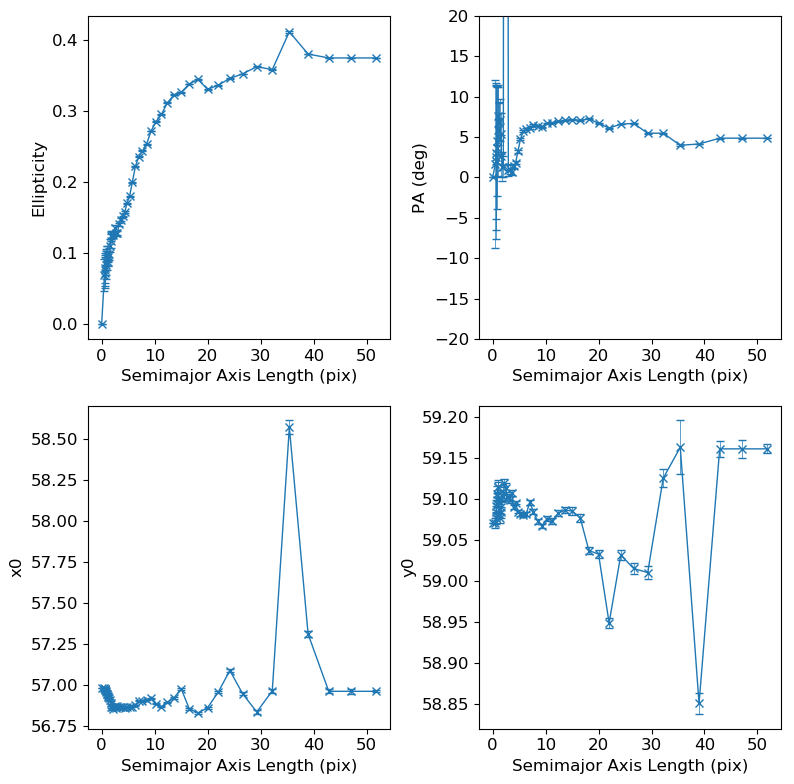

In [132]:
errbfmt = dict(marker='x', ls='-', lw=1, capsize=3, elinewidth=0.5)

plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.35)

plt.subplot(2, 2, 1)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
             **errbfmt)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('Ellipticity')

plt.subplot(2, 2, 2)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180.,
             yerr=isolist.pa_err/np.pi*180., **errbfmt)
plt.ylim(-20, +20)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('PA (deg)')

plt.subplot(2, 2, 3)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, 
             **errbfmt)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('x0')

plt.subplot(2, 2, 4)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, 
            **errbfmt)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('y0')
plt.tight_layout()

Text(0.5, 1.0, 'Residual')

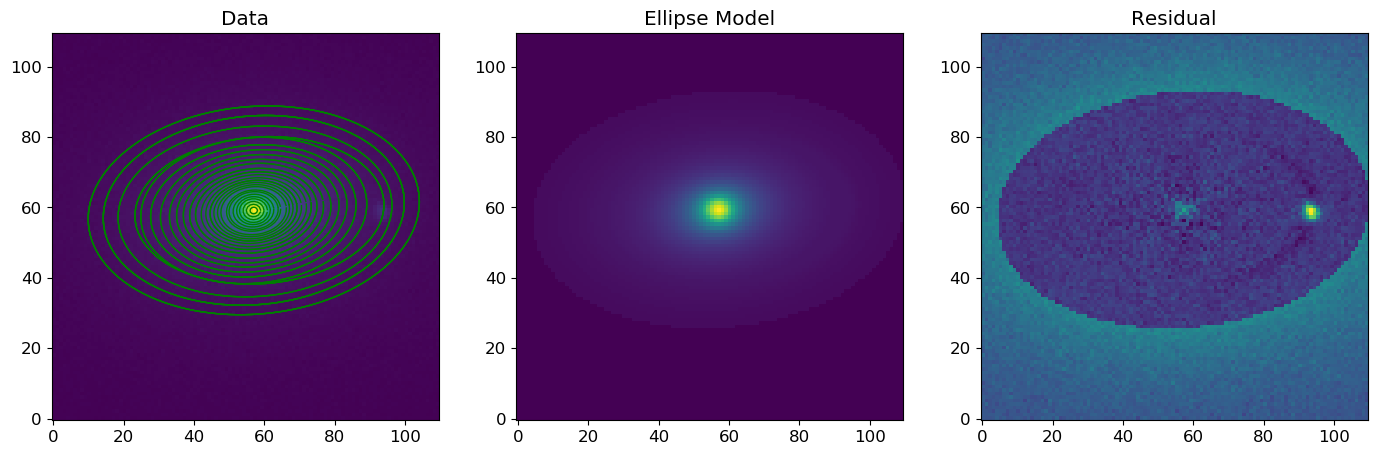

In [133]:
model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower')
ax1.set_title('Data')

smas = np.arange(50)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='g', lw=1)

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')